# Visualising heatmaps of class activations

The previous two notebooks on ConvNets covered visualising the activations of the inner layers of a ConvNet, and visualising the learned filters. This notebook will use similar tricks to see which parts of an image will influence a model to select a given output class. In more details, we'll use the pretrained VGG16 model which is originally used to predict what's in a given image, out of possible 1000 classes. We'll use a picture of an african elephant, pass it through the ConvNet to get a prediction, and use the output class to calculate the gradient of the class with respect to the activations in the last convolutional layer. In that way, we can see how a change in the last Conv layer influences the output class i.e., which parts of the image mostly influence to get the decision as is. Let's start with the image loading and preprocessing.

In [54]:
from keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet')

In [55]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

img_path = 'creative_commons_elephant.jpg'
img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [56]:
preds = model.predict(x)
print("Predicted:", decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.004354581)]


In [57]:
print("African elephant is class number:", np.argmax(preds))
print("Probability of african elephant:", preds[0, np.argmax(preds)])

African elephant is class number: 386
Probability of african elephant: 0.9094207


The following code gets the output of the model, and the last convolutional layer.

In [58]:
african_elephant_output = model.output[:, 386]  # shape: (?,)
last_conv_layer = model.get_layer("block5_conv3")
print('last_conv_layer.output.shape:', last_conv_layer.output.shape)

last_conv_layer.output.shape: (?, 14, 14, 512)


Now compute the gradients of the model output (the predicted class) with regards to the output feature map of the last convolutional layer, and average the gradients over each channel.

In [59]:
import keras.backend as K

grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
print('grads.shape:', grads.shape)

pooled_grads = K.mean(grads, axis=(0, 1, 2))
print('pooled_grads.shape:', pooled_grads.shape)

grads.shape: (?, 14, 14, 512)
pooled_grads.shape: (512,)


Create a `iterate` function that will return the gradients and the layer output of interes, given an input image. Because we're not minimising / maximising anything in this case, we can compute the needed gradients only once and apply them to the output of the last layer. Finally, average over all 512 channels to get a heatmap.

In [60]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

conv_layer_output_value[:, :, :] *= pooled_grads_value
print(conv_layer_output_value.shape)
    
heatmap = np.mean(conv_layer_output_value, axis=-1)
print(heatmap.shape)

(14, 14, 512)
(14, 14)


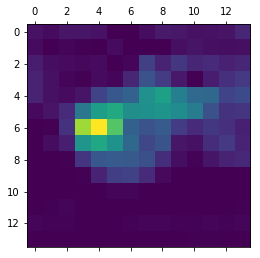

In [61]:
import matplotlib.pyplot as plt

# These two lines would improve the visualisation, but aren't mandatory
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Plot the heatmap
plt.matshow(heatmap)
plt.show()

Now how to apply the heatmap of size (14, 14) to the actual image of size (224, 224)?

The Python module `cv2` for image processing can be used in this case, to just resize the heatmap to the size of the image. The following few lines do exactly that, save the image to file, and then load and display it.

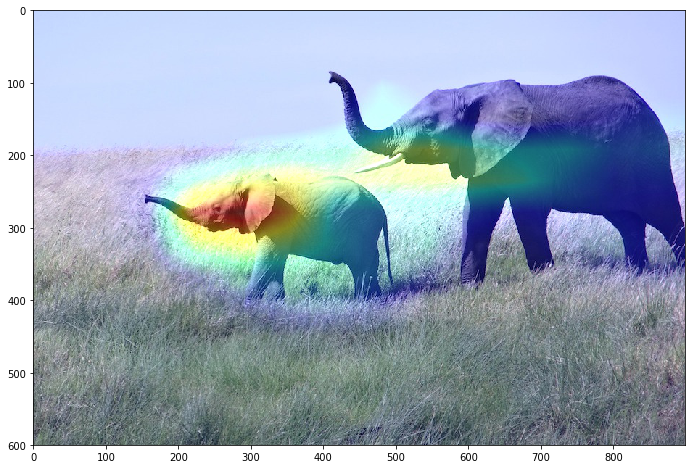

In [62]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

# To save the image to file
cv2.imwrite('elephant_cam.jpg', superimposed_img)

img_to_show = cv2.imread('elephant_cam.jpg')
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))  # .COLOR_BGR2RGB
plt.show()

Great, so this simple trick seems to work well, identifying the part of the image where there's an african elephant - mostly the small elephant and small parts of the big one. I wonder if this can be used in classification problems in standard feed-forward neural nets, or maybe even in regression problems? What if we used the gradients regarding an earlier layer in the network, instead of the last one?

I can try to answer these questions some other time, while at this moment I'm curious to see, which parts of the image associated the model to the second most likely decision - Tusker with probability 0.08618318? To answer that, I can repeat the whole process, just changing the output class to Tusker..

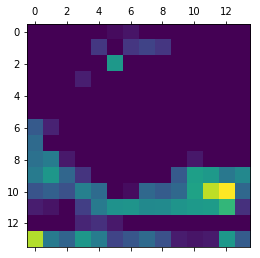

In [92]:
tusker_index = np.argwhere(preds % 0.08618318 == 0).flatten()[1]
tusker_output = model.output[:, tusker_index]

grads_tusker = K.gradients(tusker_output, last_conv_layer.output)[0]
pooled_grads_tusker = K.mean(grads_tusker, axis=(0, 1, 2))

iterate = K.function([model.input], [pooled_grads_tusker, last_conv_layer.output[0]])
pooled_grads_tusker_value, last_conv_layer_value = iterate([x])

last_conv_layer_value *= pooled_grads_tusker_value

heatmap_tusker = np.mean(last_conv_layer_value, axis=-1)

heatmap_tusker = np.maximum(heatmap_tusker, 0)
heatmap_tusker /= np.max(heatmap_tusker)

# Plot the heatmap
plt.matshow(heatmap_tusker)
plt.show()

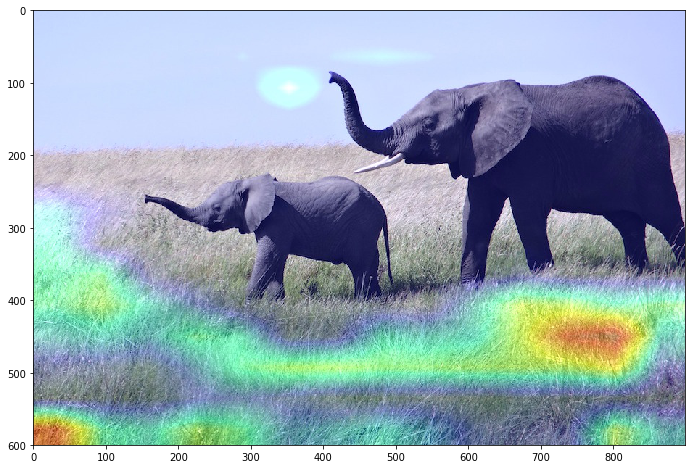

In [93]:
img = cv2.imread(img_path)
heatmap_tusker = cv2.resize(heatmap_tusker, (img.shape[1], img.shape[0]))
heatmap_tusker = np.uint8(255 * heatmap_tusker)
heatmap_tusker = cv2.applyColorMap(heatmap_tusker, cv2.COLORMAP_JET)
superimposed_img_tusker = heatmap_tusker * 0.4 + img

# To save the image to file
cv2.imwrite('elephant_cam_tusker.jpg', superimposed_img_tusker)

img_to_show = cv2.imread('elephant_cam_tusker.jpg')
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(img_to_show, cv2.COLOR_BGR2RGB))  # .COLOR_BGR2RGB
plt.show()

Well it seems that mostly the grass associated the model to a Tusker! Are elephants usually pictured in grass? Anyway, the probability of a Tusker class was just 0.08618318, so we shouldn't expect to get any strong evidence of a Tusker. 

There are some open questions at the end of this notebook which hopefully I'll be able to address soon.

## References
- "Deep Learning with Python" book by Francois Chollet